<a href="https://www.kaggle.com/code/derinjacob/ricetype?scriptVersionId=284902307" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [81]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [83]:


data_df = pd.read_csv("/kaggle/input/rice-type-classification/riceClassification.csv") 
data_df.dropna(inplace = True) 
data_df.drop(["id"], axis =1, inplace = True) 
print("Output possibilities: ", data_df["Class"].unique()) 
print("Data Shape (rows, cols): ", data_df.shape) 
data_df.head() 

Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [84]:


original_df = data_df.copy() # Creating a copy of the original Dataframe to use to normalize inference

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max() # Divide by the maximum of the column which will make max value of each column is 1
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [85]:


X = np.array(data_df.iloc[:,:-1]) 
Y = np.array(data_df.iloc[:, -1]) 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) 

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") 
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") 
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


In [86]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [87]:
training_data = dataset(X_train, y_train)
Validation_data= dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [88]:
BATCH_SIZE=32
EPOCHS=10
HIDDEN_NEURONS=10
LR=1e-3

In [89]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)
     

In [90]:
class MyModel(nn.Module):
    def __init__(self):

        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [91]:
model=MyModel().to(device)
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [92]:
criterion=nn.BCELoss()
optimizer=Adam(model.parameters(),lr=LR)

In [93]:
total_loss_tr_plot = []
total_loss_val_plot = []
total_acc_tr_plot = []
total_acc_val_plot = []


In [94]:
total_loss_tr_plot = []
total_loss_val_plot = []
total_acc_tr_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):

   
    model.train()
    total_loss_train = 0
    total_acc_train = 0
    train_samples = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction = model(inputs).squeeze(1)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()
        total_acc_train += (prediction.round() == labels).sum().item()
        train_samples += labels.size(0)

 
    model.eval()
    total_loss_val = 0
    total_acc_val = 0
    val_samples = 0

    with torch.no_grad():
        for inputs, labels in validataion_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            prediction = model(inputs).squeeze(1)
            loss = criterion(prediction, labels)

            total_loss_val += loss.item()
            total_acc_val += (prediction.round() == labels).sum().item()
            val_samples += labels.size(0)

  
    avg_train_loss = total_loss_train / len(train_dataloader)
    avg_val_loss   = total_loss_val / len(validataion_dataloader)

    train_acc = (total_acc_train / train_samples) * 100
    val_acc   = (total_acc_val / val_samples) * 100

    total_loss_tr_plot.append(avg_train_loss)
    total_loss_val_plot.append(avg_val_loss)
    total_acc_tr_plot.append(train_acc)
    total_acc_val_plot.append(val_acc)

   
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc:.2f}%"
    )
    print("-" * 50)


Epoch [1/10] | Train Loss: 0.5969 | Train Acc: 79.88% | Val Loss: 0.4661 | Val Acc: 96.19%
--------------------------------------------------
Epoch [2/10] | Train Loss: 0.3262 | Train Acc: 97.61% | Val Loss: 0.2127 | Val Acc: 98.28%
--------------------------------------------------
Epoch [3/10] | Train Loss: 0.1571 | Train Acc: 98.30% | Val Loss: 0.1174 | Val Acc: 98.31%
--------------------------------------------------
Epoch [4/10] | Train Loss: 0.0983 | Train Acc: 98.37% | Val Loss: 0.0809 | Val Acc: 98.64%
--------------------------------------------------
Epoch [5/10] | Train Loss: 0.0741 | Train Acc: 98.51% | Val Loss: 0.0643 | Val Acc: 98.57%
--------------------------------------------------
Epoch [6/10] | Train Loss: 0.0616 | Train Acc: 98.63% | Val Loss: 0.0548 | Val Acc: 98.61%
--------------------------------------------------
Epoch [7/10] | Train Loss: 0.0548 | Train Acc: 98.56% | Val Loss: 0.0482 | Val Acc: 98.68%
--------------------------------------------------
Epoch 

In [95]:

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")
     

Accuracy Score is: 98.46%


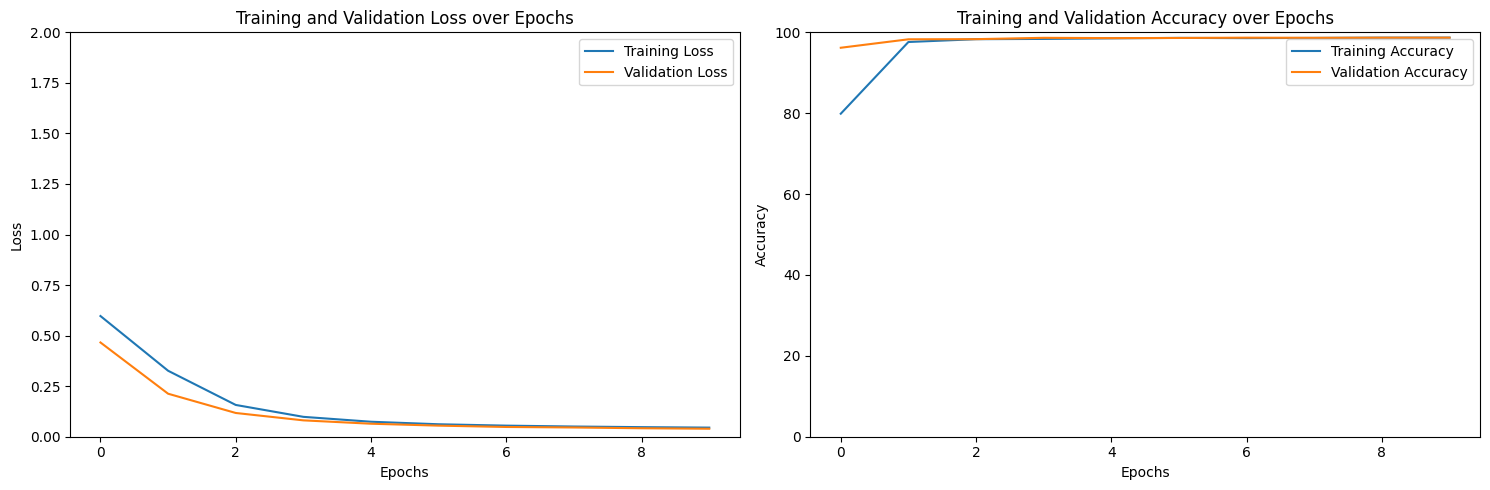

In [97]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_tr_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_tr_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()